# 02 — Baseline Model (Logistic Regression)

C:\Users\mayfair440\Downloads\govind_data_projects_starter\telco-churn-quickstart\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC: 0.84
              precision    recall  f1-score   support

           0      0.852     0.886     0.869      1291
           1      0.647     0.576     0.609       467

    accuracy                          0.804      1758
   macro avg      0.750     0.731     0.739      1758
weighted avg      0.798     0.804     0.800      1758



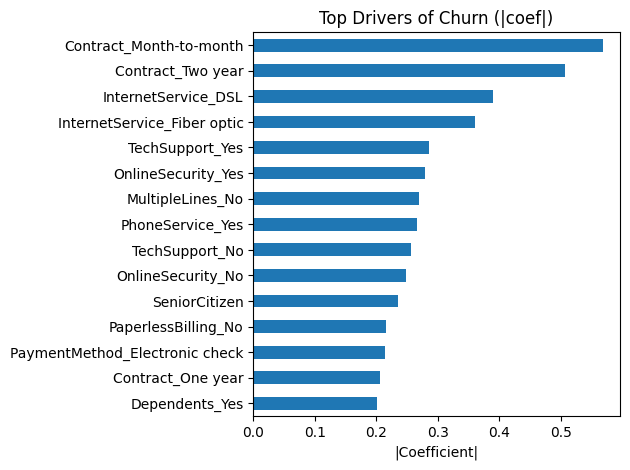

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Load
df = pd.read_csv('data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).copy()
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

# Features / target
y = df['Churn'].values
X = df.drop(columns=['Churn', 'customerID'])
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

pre = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

clf = Pipeline([
    ('prep', pre),
    ('lr', LogisticRegression(max_iter=200, n_jobs=None))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, proba)
print('ROC AUC:', round(auc, 3))
print(classification_report(y_test, pred, digits=3))

# Save basic metric
Path('assets').mkdir(exist_ok=True)
with open('assets/metrics.json','w') as f:
    import json
    json.dump({'roc_auc': float(auc)}, f, indent=2)

# Feature importances (absolute LR coefficients tied to OHE feature names)
ohe = clf.named_steps['prep'].named_transformers_['ohe']
feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols
coefs = clf.named_steps['lr'].coef_[0]
importances = pd.Series(np.abs(coefs), index=feature_names).sort_values(ascending=False).head(15)

plt.figure()
importances[::-1].plot(kind='barh')
plt.title('Top Drivers of Churn (|coef|)')
plt.xlabel('|Coefficient|')
plt.tight_layout()
plt.savefig('assets/top_drivers.png', bbox_inches='tight')
plt.show()
